## One thinking: We can treat SABR model as 2D considering the symmetry, at the price of increasing the range of $\alpha_0$
https://hpcquantlib.wordpress.com/2019/10/12/almost-exact-sabr-interpolation-using-neural-networks-and-gradient-boosted-trees/

$F_t  \rightarrow \lambda F_t $

$\alpha_t \rightarrow \lambda ^{1-\beta} \alpha_t$

$\sigma(K,F_0,T,\alpha, \beta, \nu, \rho) = \sigma(\lambda K,\lambda F_0,T,\lambda ^{1-\beta}\alpha, \beta, \nu, \rho)$

With the formula above we can fix $F_0 = 1.0$ without loss of generality. We can increase the range of $\alpha_0$ to $[0,1]$

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
from utilities3 import *

torch.manual_seed(0)
np.random.seed(0)

################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """

        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(12, self.width) # input channel is 3: (a(1,x),a(2,x),...,a(10,x), x, t)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2] #x for S, y for t

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## First Test: Extrapolation
T = 5

time_steps = np.linsapce(0.1,T,50)

Input data: C(alpha) for the first 10 time steps

Output data: C(alpha) for the last 40 time steps

In [2]:
################################################################
# configs
################################################################
TRAIN_PATH = 'data/SABR2D.mat'
TEST_PATH = 'data/SABR2D.mat'

ntrain = 900
ntest = 100

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 12
width = 32

sub = 1
S = 50 // sub
T_in = 10
T = 40

path = 'SABR2D'
path_model = 'model/'+path
t1 = default_timer()
################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)
train_a = reader.read_field('u')[:ntrain,::sub,:T_in]
train_u = reader.read_field('u')[:ntrain,::sub,T_in:T+T_in]

reader = MatReader(TEST_PATH)
test_a = reader.read_field('u')[-ntest:,::sub,:T_in]
test_u = reader.read_field('u')[-ntest:,::sub,T_in:T+T_in]

print(train_u.shape)
print(test_u.shape)
assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])

a_normalizer = UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

train_a = train_a.reshape(ntrain,S,1,T_in).repeat([1,1,T,1])
test_a = test_a.reshape(ntest,S,1,T_in).repeat([1,1,T,1])


# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0.0035, 0.0095, S), dtype=torch.float)
gridx = gridx.reshape(1, S,  1, 1).repeat([1, 1, T, 1])
gridt = torch.tensor(np.linspace(0.1, 5, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1,  T, 1).repeat([1, S,  1, 1])

train_a = torch.cat((gridx.repeat([ntrain,1,1,1]),
                       gridt.repeat([ntrain,1,1,1]), train_a), dim=-1)
test_a = torch.cat((gridx.repeat([ntest,1,1,1]),
                       gridt.repeat([ntest,1,1,1]), test_a), dim=-1)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')
################################################################
# training and evaluation
################################################################
model = FNO2d(modes, modes, width).cuda()
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    train_mse = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).view(batch_size, S, T)

        mse = F.mse_loss(out, y, reduction='mean')

        y = y_normalizer.decode(y)
        out = y_normalizer.decode(out)
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).view(batch_size, S, T)
            out = y_normalizer.decode(out)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

torch.save(model, path_model)

pred = torch.zeros(test_u.shape)
benchmark = torch.zeros(test_u.shape)
inputs = torch.zeros(test_a.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x).squeeze()
        out = y_normalizer.decode(out)
        pred[index] = out
        benchmark[index] = y.squeeze()
        inputs[index] = x
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

scipy.io.savemat('pred/'+path+'.mat', mdict={'pred': pred.cpu().numpy(),
                                             'benchmark':benchmark.cpu().numpy(),
                                              'inputs':inputs.cpu().numpy()})

torch.Size([900, 50, 40])
torch.Size([100, 50, 40])
preprocessing finished, time used: 0.23881139999999945
1188897
0 4.041111100000002 0.44303779631025264 0.2173057864771949 0.06758493423461914
1 0.5189765000000008 0.008548475465633802 0.03409687648216883 0.021430383324623107
2 0.5048100999999967 0.0033250401236323847 0.021969967583815257 0.018576095402240752
3 0.5125516999999995 0.003385577019717958 0.021592359211709763 0.021331112384796142
4 0.5265230999999986 0.003363957882134451 0.0223255721728007 0.020676775574684142
5 0.5255606999999998 0.0029776048510231907 0.019312235083844928 0.02441582441329956
6 0.4945480999999958 0.0029392327880486844 0.021833787510792416 0.026613560020923615
7 0.4838604999999987 0.003290176551996006 0.019906146857473585 0.01769200176000595
8 0.48793840000000444 0.003383044893335965 0.01997168762816323 0.026040578186511995
9 0.4977413000000013 0.003275916094167365 0.020889572732978395 0.03150145411491394
10 0.4839827999999997 0.0031911421023930113 0.0211744

The price predicted from the model for the last 40 time steps(blue dots) and the ground truth(colored surface)

Text(0.5, 0, 'alpha')

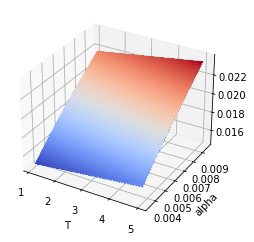

In [42]:
pred = scipy.io.loadmat('pred/SABR2D.mat')
predicted = pred['pred']
groundtruth = pred['benchmark']

from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
tempx = np.linspace(0.1,5,50)
t = tempx[10:]
s = np.linspace(0.0035,0.0095,50)
N = 10
[tgrid,sgrid] = np.meshgrid(t,s)
ax.plot_surface(tgrid,sgrid,groundtruth[N,:,:].reshape(50,40),cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,label = 'groundtruth')
ax.scatter(tgrid,sgrid,predicted[N,:,:].reshape(50,40),s=1,label = 'predicted')

ax.set_xlabel('T')
ax.set_ylabel('alpha')

#ax.view_init(45, 45)

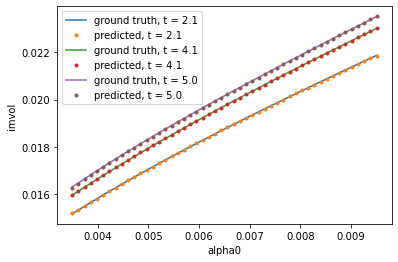

mae is 8.441527024842799e-07


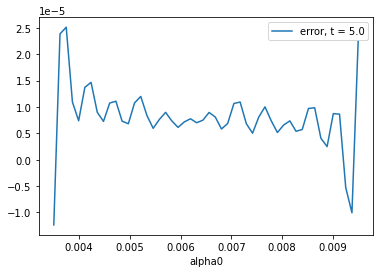

In [61]:
plt.figure()
N = 10
Nt = 10
tempx = np.linspace(0.1,5,50)
t = tempx[10:]
plt.plot(s,groundtruth[N,:,Nt],label = 'ground truth, t = ' + str(t[Nt]))
plt.plot(s,predicted[N,:,Nt],'.',label = 'predicted, t = '+ str(t[Nt]))

Nt = 30
plt.plot(s,groundtruth[N,:,Nt],label = 'ground truth, t = ' + str(t[Nt]))
plt.plot(s,predicted[N,:,Nt],'.',label = 'predicted, t = '+ str(t[Nt]))



Nt = 39
plt.plot(s,groundtruth[N,:,Nt],label = 'ground truth, t = ' + str(t[Nt]))
plt.plot(s,predicted[N,:,Nt],'.',label = 'predicted, t = '+ str(t[Nt]))

plt.xlabel('alpha0')
plt.ylabel('imvol')
plt.legend()
plt.show()


NN = 1024*50*40
mae = np.sum(np.abs(groundtruth - predicted))/NN
print('mae is ' + str(mae))

plt.figure()
N = 39
plt.plot(s,groundtruth[N,:,Nt]-predicted[N,:,Nt],label = 'error, t = ' + str(t[Nt]))
plt.xlabel('alpha0')
plt.legend()

In [22]:
################################################################
# configs
################################################################
TRAIN_PATH = 'data/SABR2D.mat'
TEST_PATH = 'data/SABR2D.mat'

ntrain = 1000
ntest = 100

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 12
width = 32

sub = 1
S = 50// sub

T_in = 10
T = 40

index_train_u = np.ones((50,),dtype=bool)
index_train_u[::5] = False
index_train_a = ~index_train_u
#temp = np.linspace(0,49,50)
#index_train_a = temp[index_train_a]
#index_train_u = temp[index_train_u]


path = 'SABR2D_interp'
path_model = 'model/'+path
t1 = default_timer()
################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)
train_a = reader.read_field('u')[:ntrain,::sub,index_train_a]
train_u = reader.read_field('u')[:ntrain,::sub,index_train_u]

reader = MatReader(TEST_PATH)
test_a = reader.read_field('u')[-ntest:,::sub,index_train_a]
test_u = reader.read_field('u')[-ntest:,::sub,index_train_u]

print(train_u.shape)
print(test_u.shape)
print(test_a.shape)
print(train_a.shape)
#assert (S == train_u.shape[-2])
#assert (T == train_u.shape[-1])

a_normalizer = UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

train_a = train_a.reshape(ntrain,S,1,T_in).repeat([1,1,T,1])
test_a = test_a.reshape(ntest,S,1,T_in).repeat([1,1,T,1])


# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0.0035, 0.0095, S), dtype=torch.float)
gridx = gridx.reshape(1, S,  1, 1).repeat([1, 1, T, 1])
gridt = torch.tensor(np.linspace(0.1, 5, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1,  T, 1).repeat([1, S,  1, 1])

train_a = torch.cat((gridx.repeat([ntrain,1,1,1]),
                       gridt.repeat([ntrain,1,1,1]), train_a), dim=-1)
test_a = torch.cat((gridx.repeat([ntest,1,1,1]),
                       gridt.repeat([ntest,1,1,1]), test_a), dim=-1)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')
################################################################
# training and evaluation
################################################################
model = FNO2d(modes, modes, width).cuda()
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    train_mse = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).view(batch_size, S, T)

        mse = F.mse_loss(out, y, reduction='mean')

        y = y_normalizer.decode(y)
        out = y_normalizer.decode(out)
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).view(batch_size, S, T)
            out = y_normalizer.decode(out)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

torch.save(model, path_model)

pred = torch.zeros(test_u.shape)
benchmark = torch.zeros(test_u.shape)
inputs = torch.zeros(test_a.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x).squeeze()
        out = y_normalizer.decode(out)
        pred[index] = out
        benchmark[index] = y.squeeze()
        inputs[index] = x
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

scipy.io.savemat('pred/'+path+'.mat', mdict={'pred': pred.cpu().numpy(),
                                             'benchmark':benchmark.cpu().numpy(),
                                              'inputs':inputs.cpu().numpy()})


torch.Size([1000, 50, 40])
torch.Size([100, 50, 40])
torch.Size([100, 50, 10])
torch.Size([1000, 50, 10])
preprocessing finished, time used: 0.20344309999995858
1188897
0 0.6628570000000309 0.41429178352467716 0.20962792986631393 0.03193320751190185
1 0.5871849000000111 0.0022569504496641455 0.019893555715680123 0.01510072559118271
2 0.5704965999999558 0.001976758512901142 0.021167928487062455 0.030425782203674315
3 0.5584109000000126 0.0015925054217223078 0.01680757309496403 0.01575989454984665
4 0.5452976000000263 0.001621652973117307 0.018986675843596458 0.014902281165122986
5 0.5585758999999371 0.0009241471526911482 0.013736287355422974 0.011154962927103043
6 0.5461669999999685 0.0017148238653317094 0.020400560319423677 0.015510252416133881
7 0.5628889999999274 0.0009565783338621259 0.011867920726537704 0.009701349288225174
8 0.5443351999999777 0.0014130487537477165 0.01763254351913929 0.018595707416534425
9 0.5608723999999938 0.002481272666482255 0.021476315319538117 0.02604782402

In [28]:
path_model

'model/SABR2D_interp'

## The Second Test: Interpolation
T = 5

time_steps = np.linsapce(0.1,T,50)

Input data: C(alpha) for the evenly spaced 10 time steps time_steps[::5]

Output data: C(alpha) for the remaining 40 time steps

Text(0.5, 0, 'S')

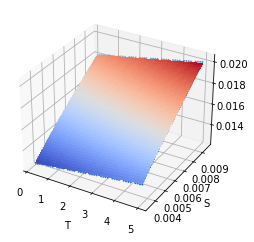

In [58]:
pred = scipy.io.loadmat('pred/SABR2D_interp.mat')
predicted = pred['pred']
groundtruth = pred['benchmark']

from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
index_train_u = np.ones((50,),dtype=bool)
index_train_u[::5] = False
index_train_a = ~index_train_u
tempx = np.linspace(0.1,5,50)
t = tempx[index_train_u]
s = np.linspace(0.0035,0.0095,50)
N = 21
[tgrid,sgrid] = np.meshgrid(t,s)
ax.plot_surface(tgrid,sgrid,groundtruth[N,:,:].reshape(50,40),cmap=cm.coolwarm,
                       linewidth=1, antialiased=False,label = 'groundtruth')
ax.scatter(tgrid,sgrid,predicted[N,:,:].reshape(50,40),s=1,label = 'predicted')

ax.set_xlabel('T')
ax.set_ylabel('S')

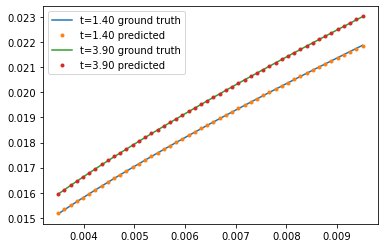

mae is 8.441527024842799e-07


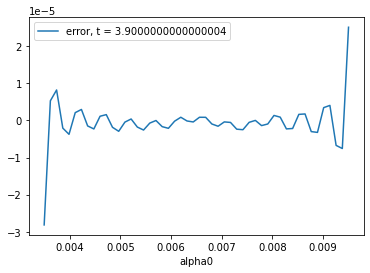

In [60]:
plt.figure()
N = 10
Nt = 10
plt.plot(s,groundtruth[N,:,Nt],label = 't='+'{:.2f}'.format(t[Nt])+' ground truth')
plt.plot(s,predicted[N,:,Nt],'.',label = 't='+'{:.2f}'.format(t[Nt])+' predicted')

Nt = 30
plt.plot(s,groundtruth[N,:,Nt],label = 't='+'{:.2f}'.format(t[Nt])+' ground truth')
plt.plot(s,predicted[N,:,Nt],'.',label = 't='+'{:.2f}'.format(t[Nt])+' predicted')

plt.legend()
plt.show()



NN = 1024*50*40
mae = np.sum(np.abs(groundtruth - predicted))/NN

print('mae is '+ str(mae))

plt.figure()
N = 39
plt.plot(s,groundtruth[N,:,Nt]-predicted[N,:,Nt],label = 'error, t = ' + str(t[Nt]))
plt.xlabel('alpha0')
plt.legend()